In [1]:
import lib.tf_silent
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from lib.pinn import PINN
from lib.network import Network
from lib.optimizer import L_BFGS_B
import time
import scipy.io

In [2]:
starttime = time.time()

"""
Test the physics informed neural network (PINN) model for Burgers' equation
"""

# number of training samples
num_train_samples = 2560
# number of test samples
num_test_samples = 256
# kinematic viscosity
nu = 0.01 / np.pi

In [3]:
# build a core network model
network = Network.build()
network.summary()
# build a PINN model
pinn = PINN(network, nu).build()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 32)                96        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,201
Trainable params: 1,201
Non-trainable params: 0
_________________________________________________________________


In [4]:
# create training input
tx_eqn = np.random.rand(num_train_samples, 2)          # t_eqn =  0 ~ +1
tx_eqn[..., 1] = 2 * tx_eqn[..., 1] - 1                # x_eqn = -1 ~ +1
tx_ini = 2 * np.random.rand(num_train_samples, 2) - 1  # x_ini = -1 ~ +1
tx_ini[..., 0] = 0                                     # t_ini =  0
tx_bnd = np.random.rand(num_train_samples, 2)          # t_bnd =  0 ~ +1
tx_bnd[..., 1] = 2 * np.round(tx_bnd[..., 1]) - 1      # x_bnd = -1 or +1
# create training output
u_eqn = np.zeros((num_train_samples, 1))               # u_eqn = 0
u_ini = np.sin(-np.pi * tx_ini[..., 1, np.newaxis])    # u_ini = -sin(pi*x_ini)
u_bnd = np.zeros((num_train_samples, 1))               # u_bnd = 0

In [5]:
# train the model using L-BFGS-B algorithm
ttime = time.time()
x_train = [tx_eqn, tx_ini, tx_bnd]
y_train = [ u_eqn,  u_ini,  u_bnd]
lbfgs = L_BFGS_B(model=pinn, x_train=x_train, y_train=y_train)
lbfgs.fit()
ttime = time.time() - ttime

Optimizer: L-BFGS-B (maxiter=5000)
5000/5000 [==============================] - 547s 109ms/step


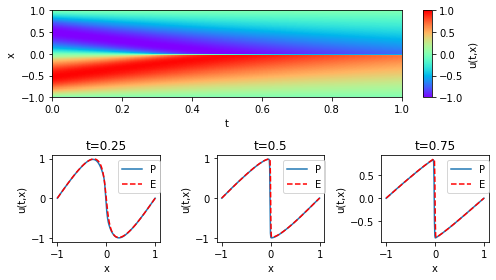

P is predicted, E is exact


In [6]:
# predict u(t,x) distribution
t_flat = np.linspace(0, 1, num_test_samples)
x_flat = np.linspace(-1, 1, num_test_samples)
t, x = np.meshgrid(t_flat, x_flat)
tx = np.stack([t.flatten(), x.flatten()], axis=-1)
u = network.predict(tx, batch_size=num_test_samples)
u = u.reshape(t.shape)

# Loading the Exact Solution
data = scipy.io.loadmat('burgers_shock.mat')
Exact = np.real(data['usol'])

# plot u(t,x) distribution as a color-map
fig = plt.figure(figsize=(7,4))
gs = GridSpec(2, 3)
plt.subplot(gs[0, :])
plt.pcolormesh(t, x, u[:-1, :-1], cmap='rainbow')
plt.xlabel('t')
plt.ylabel('x')
cbar = plt.colorbar(pad=0.05, aspect=10)
cbar.set_label('u(t,x)')
cbar.mappable.set_clim(-1, 1)
# plot u(t=const, x) cross-sections
t_cross_sections = [0.25, 0.5, 0.75]
for i, t_cs in enumerate(t_cross_sections):
    plt.subplot(gs[1, i])
    tx = np.stack([np.full(t_flat.shape, t_cs), x_flat], axis=-1)
    u = network.predict(tx, batch_size=num_test_samples)
    plt.plot(x_flat, u)
    plt.plot(np.linspace(-1,1,256),Exact[:,int(100 * t_cs)], 'r--')
    plt.title('t={}'.format(t_cs))
    plt.xlabel('x')
    plt.ylabel('u(t,x)')
    plt.legend(["P", "E"],bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

endtime = time.time() - starttime
print("P is predicted, E is exact")

In [7]:
print("The whole process took {0:.3f} seconds".format(endtime))
print("The training took {0:.3f} seconds".format(ttime))

The whole process took 554.647 seconds
The training took 547.139 seconds


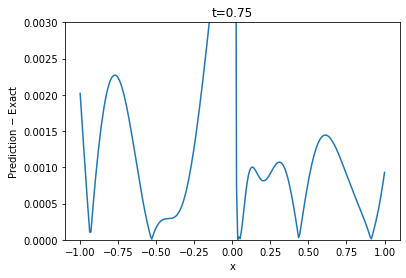

The maximum error was 1.304 at x = -0.011765


In [10]:
# Showing the error of the neural network
err = abs(u[:,0]-Exact[:,int(t_cs * 100)])
plt.plot(x_flat,err)
plt.ylim(0,.003)
plt.title('t={}'.format(t_cs))
plt.xlabel('x')
plt.ylabel(r'Prediction $-$ Exact')
plt.show()
print('The maximum error was {0:.3f} at x = {1:.6f}'.format( np.max(err), ( -1 + (2 * np.argmax(err) )/255 ) ))